<a href="https://www.kaggle.com/code/krviswanathan/credit-card-fraud-baseline-smote-ensemble?scriptVersionId=117589787" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")

color1 = ["#00B4D8"]
sns.set_palette(sns.color_palette(color1))

pd.set_option('display.max_columns', None)

### Load the data

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s3e4/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s3e4/test.csv')
df_orig = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# EDA

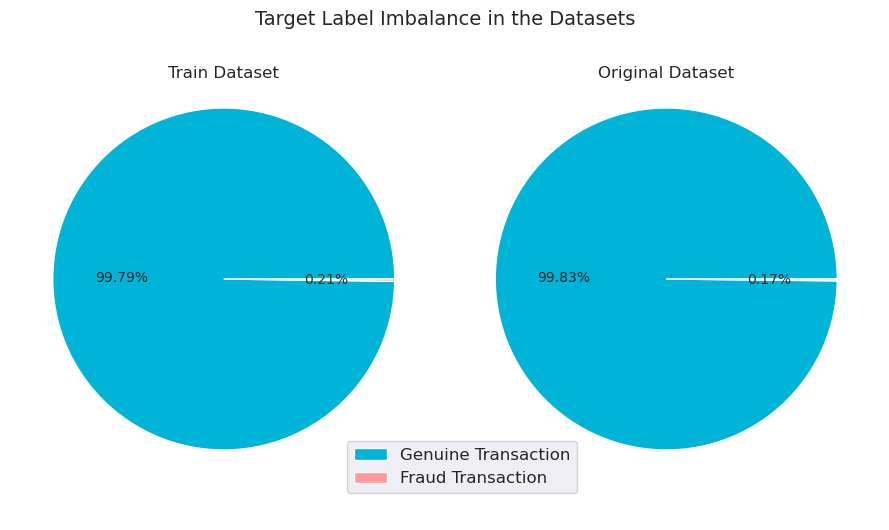

In [3]:
custom_colors = ["#00B4D8", "#ff9999"]
label = ['Genuine Transaction', 'Fraud Transaction']
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, dpi=100)
fig.suptitle('Target Label Imbalance in the Datasets', y=0.92, fontsize=14)
df_train['Class'].value_counts().plot(kind='pie', autopct='%0.2f%%',  fontsize=10, figsize=(9,6), 
                                    colors=custom_colors, startangle=0, ax=ax1, labels=None)

df_orig['Class'].value_counts().plot(kind='pie', autopct='%0.2f%%',  fontsize=10, figsize=(9,6), 
                                    colors=custom_colors, startangle=0, ax=ax2, labels=None)

ax1.set_ylabel('')
ax1.set_title('Train Dataset', size=12, y=0.95);


ax2.set_ylabel('')
ax2.set_title('Original Dataset', size=12, y=0.95)
fig.legend(label, loc=(0.39, 0.07), fontsize=12)
plt.tight_layout()

**Insights:**

* The train dataset contains 219129 observations with 32 features and no missing values.


* The test dataset contains 146087 non-null observations with 31 features.


* The original dataset has 284807 non-null entries with 32 features.


* The pie chart illustrates the significant imbalance of the target label `Class` in both the train and original datasets. As shown in the chart, only a small fraction of the records, 0.21% and 0.17% respectively, correspond to `Fraud` transactions in the train and original datasets.

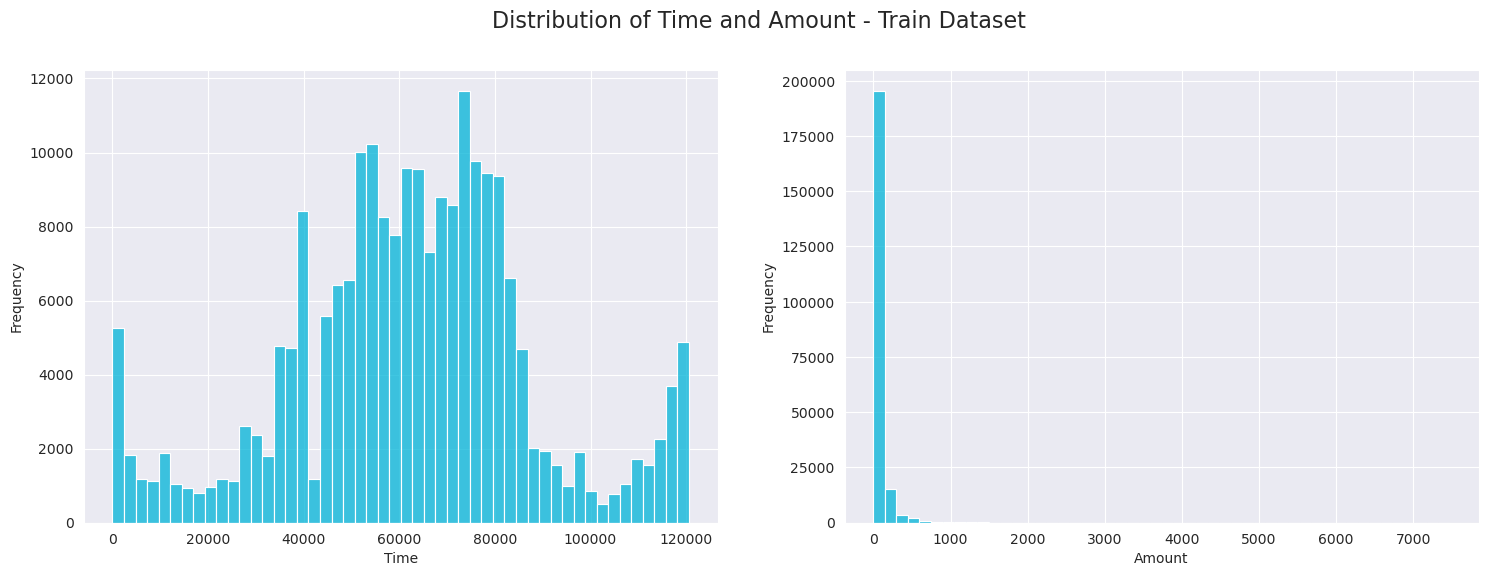

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), dpi=100)
fig.suptitle('Distribution of Time and Amount - Train Dataset', fontsize=16)
sns.histplot(data=df_train, x='Time', bins=50, ax=ax1, color=color1)
sns.histplot(data=df_train, x='Amount', bins=50, ax=ax2, color=color1)
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Frequency');

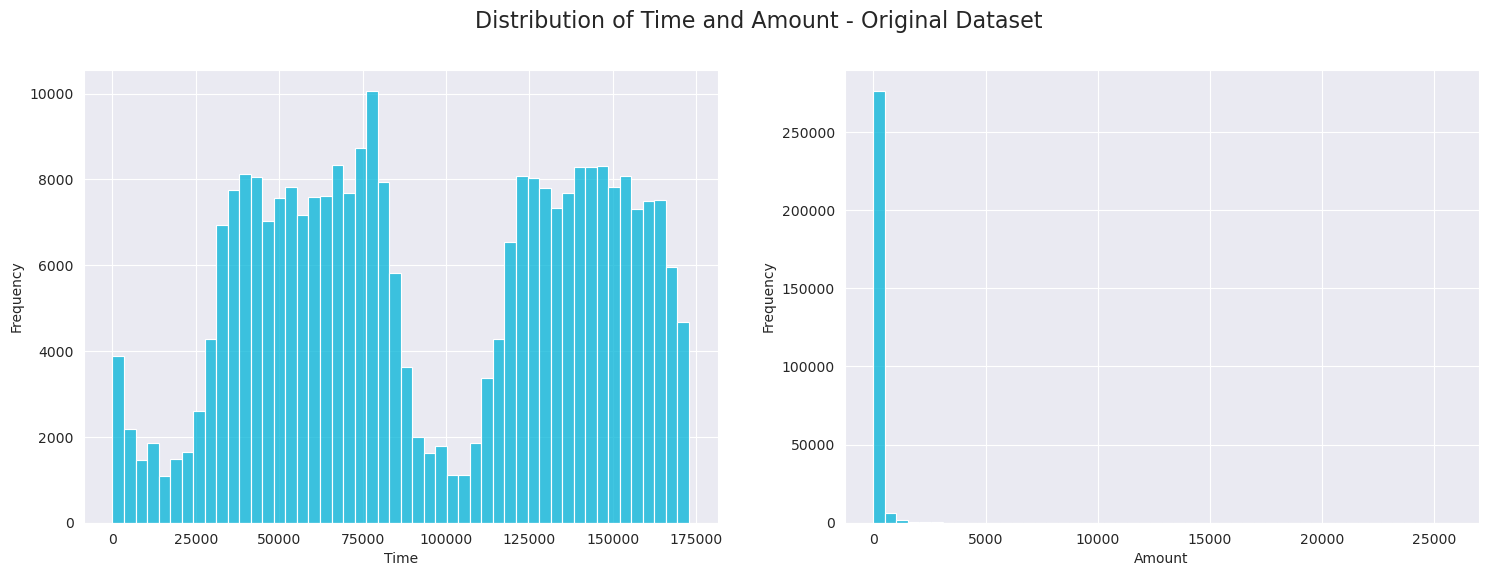

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), dpi=100)
fig.suptitle('Distribution of Time and Amount - Original Dataset', fontsize=16)
sns.histplot(data=df_orig, x='Time', bins=50, ax=ax1, color=color1)
sns.histplot(data=df_orig, x='Amount', bins=50, ax=ax2, color=color1)
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Frequency');

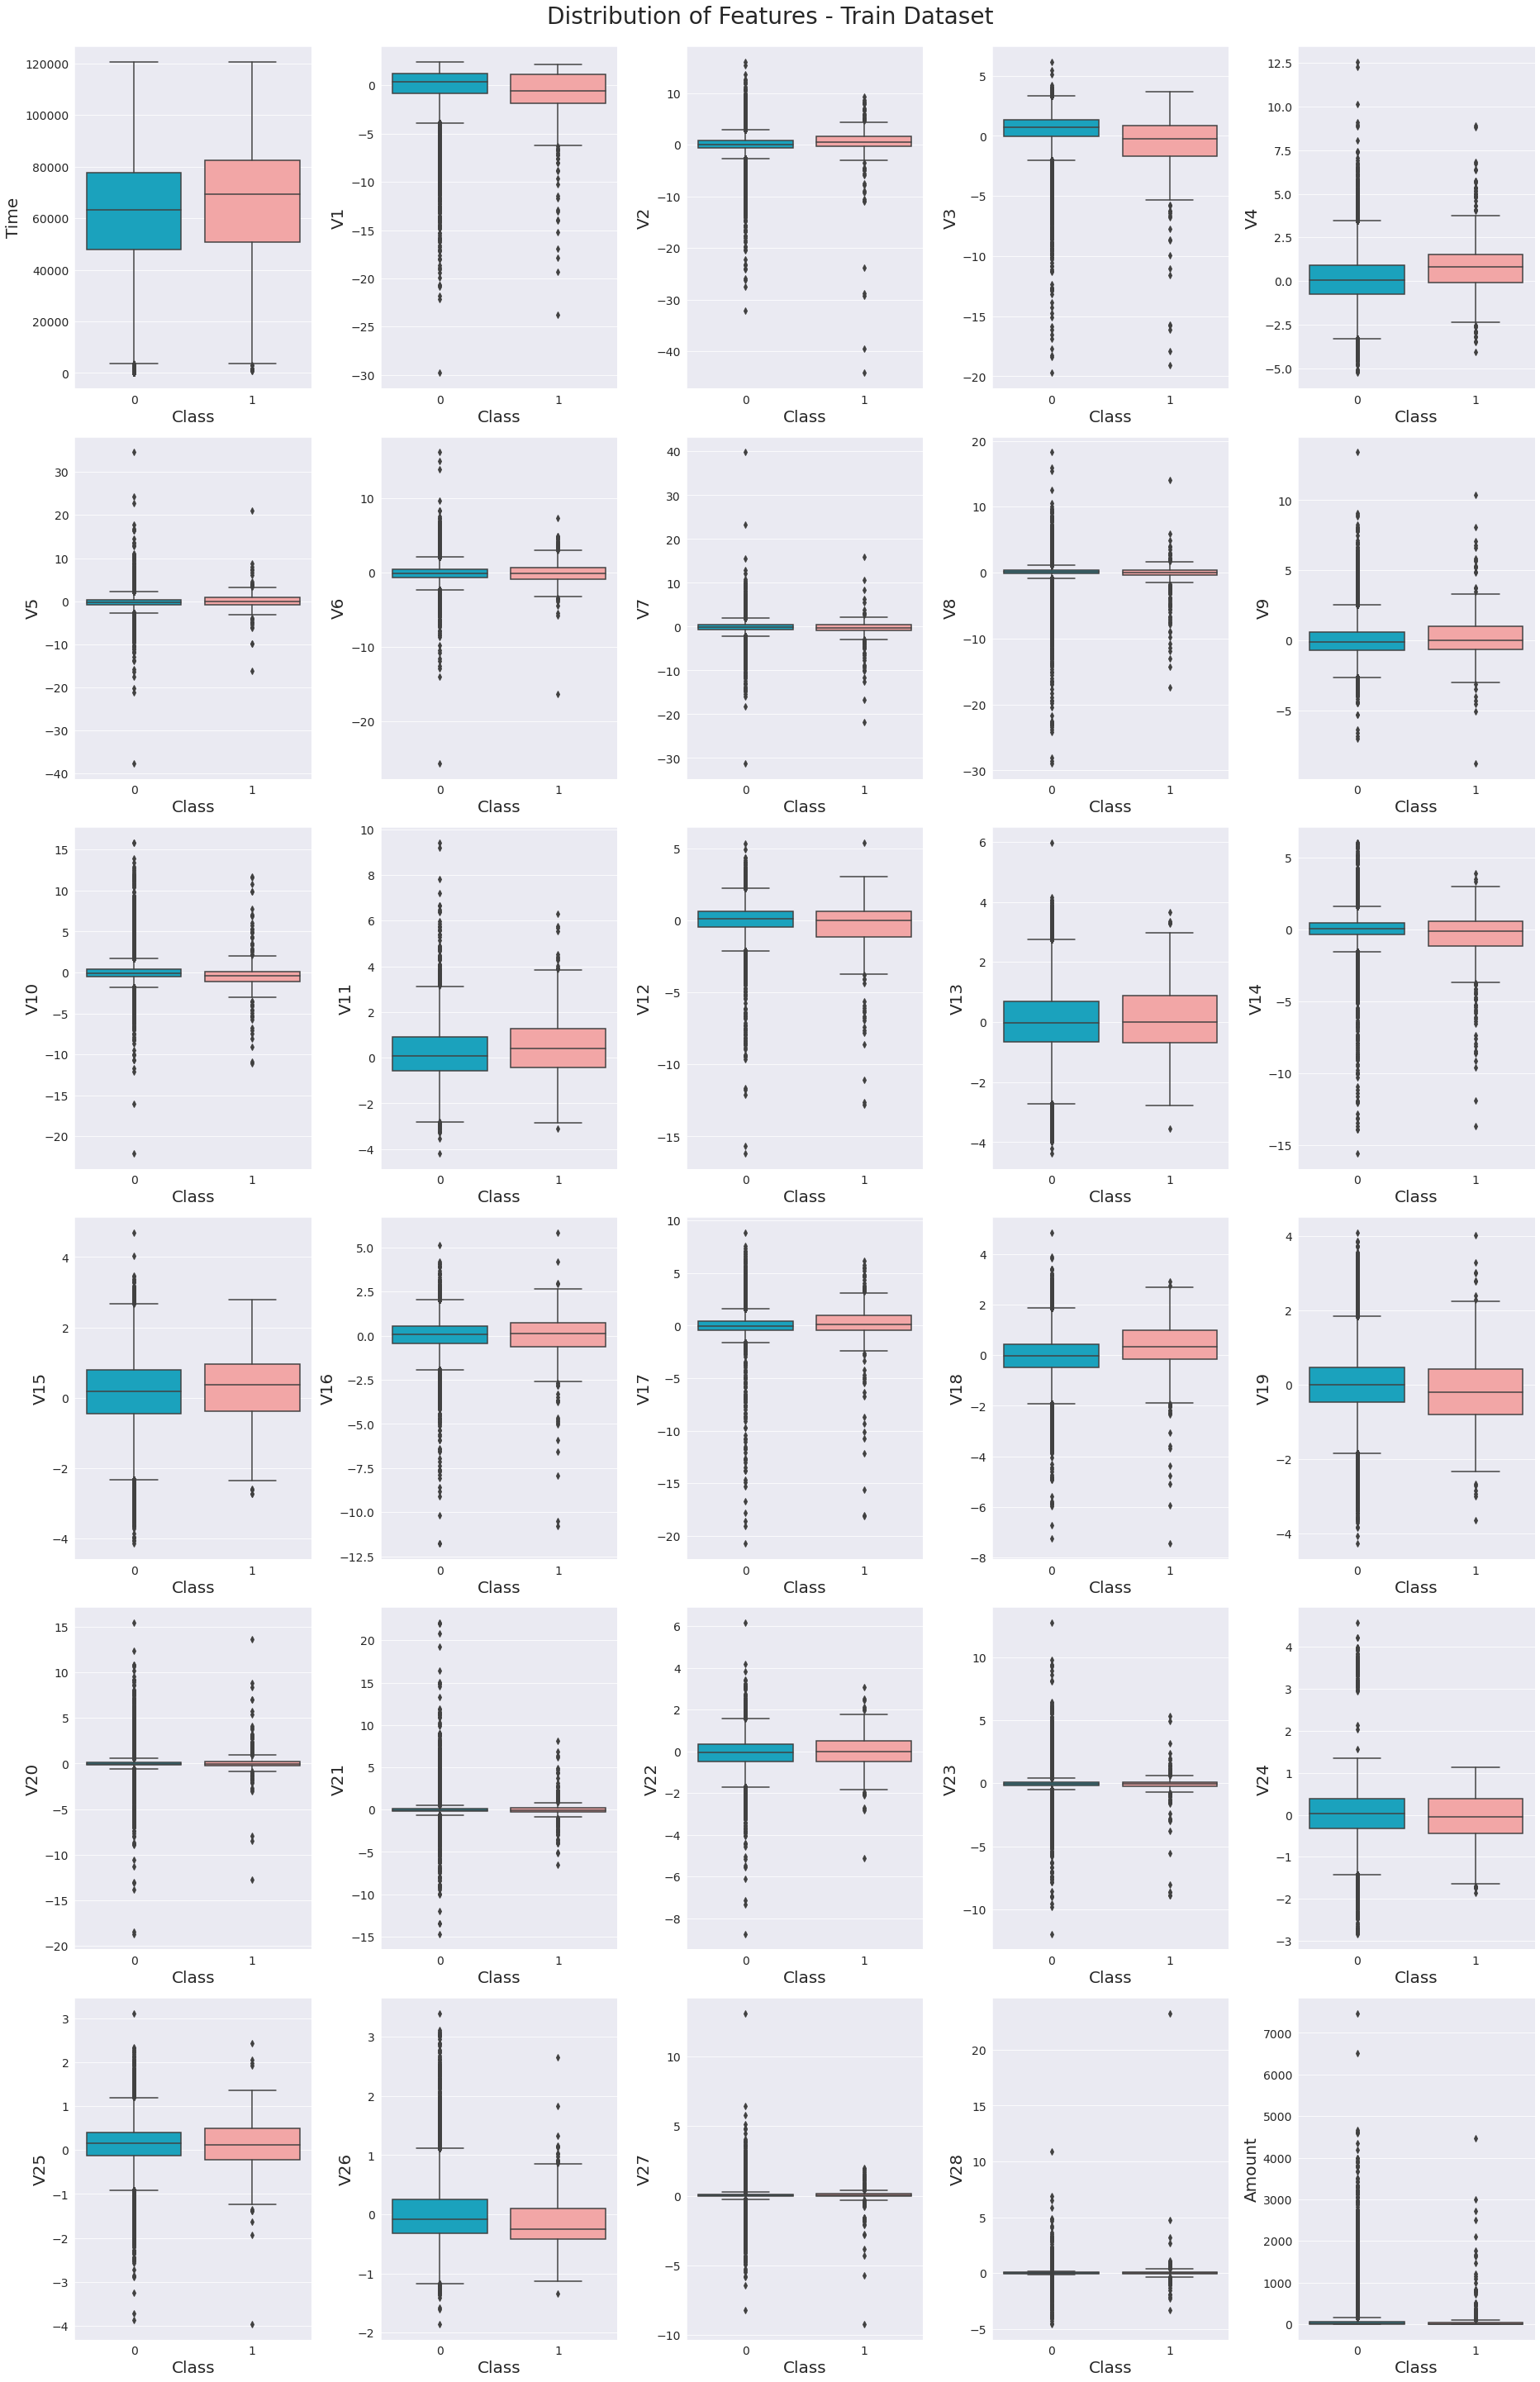

In [6]:
continous_cols = list(df_train.select_dtypes(exclude='int64').columns)

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(26, 40))
fig.suptitle('Distribution of Features - Train Dataset', y=1.00, fontsize=28)
for col, ax in zip(continous_cols, axes.ravel()):
    sns.boxplot(data=df_train, x='Class', y=col, palette=custom_colors, ax=ax)
    ax.set_xlabel('Class', fontsize=20)
    ax.set_ylabel(col, fontsize=20)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
plt.tight_layout()

### Feature Correlation

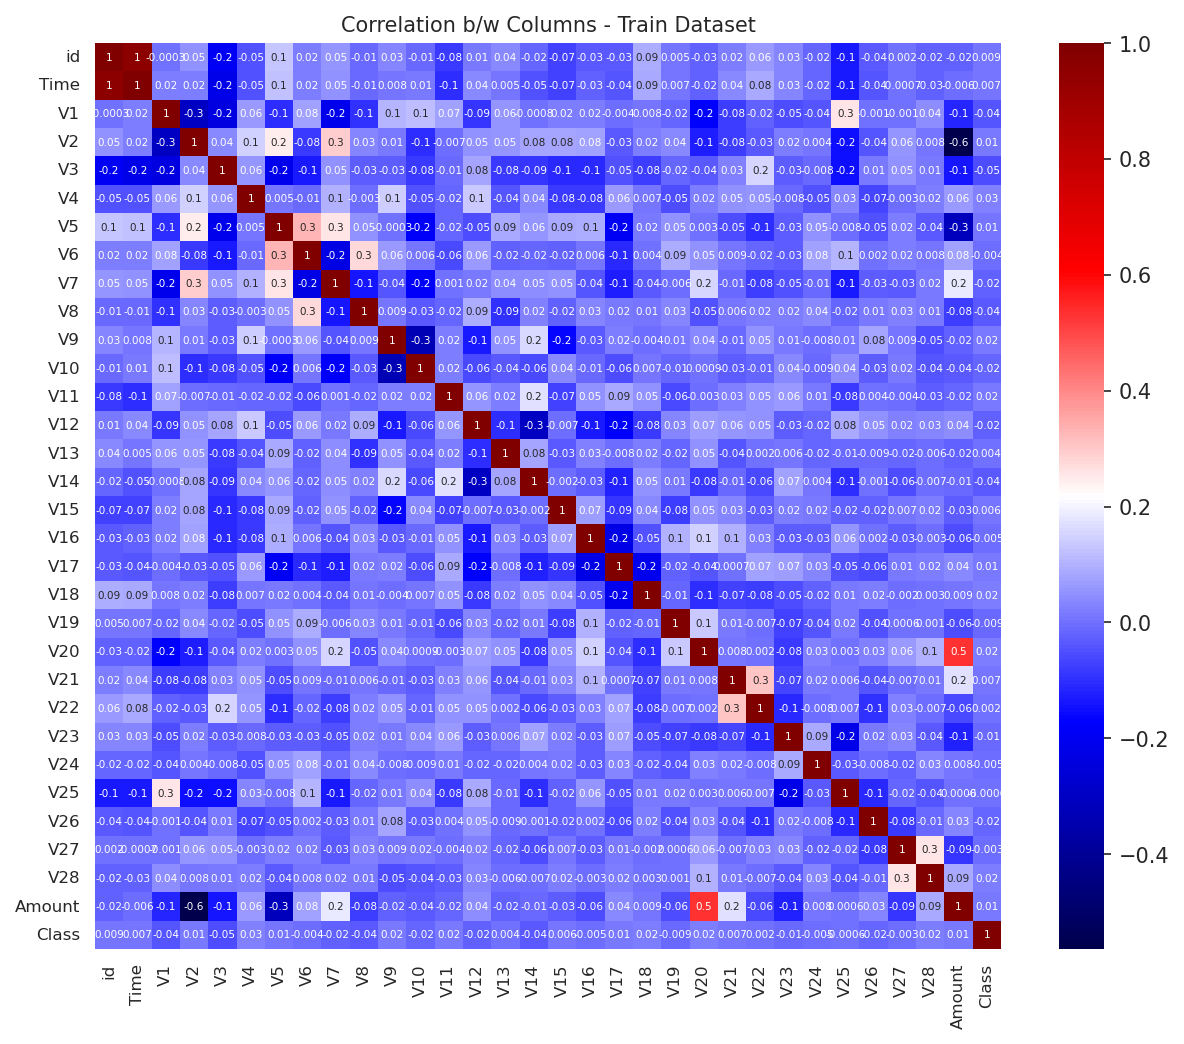

In [7]:
corr_train = df_train.corr()
fig = plt.figure(figsize=(10,8), dpi=150)
sns.heatmap(corr_train, square=True, annot=True, fmt='0.1g', cmap='seismic', annot_kws={'size' : 5})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Correlation b/w Columns - Train Dataset', fontsize=10);

**Insights:**

* `Amount` column has negative correlation with `V2` and `V5` whereas it has positive correlation with `V20` and `V21`. 


* `V21` and `V22` are positively correlated with each other.


* `Class` label has no correlation with any column.

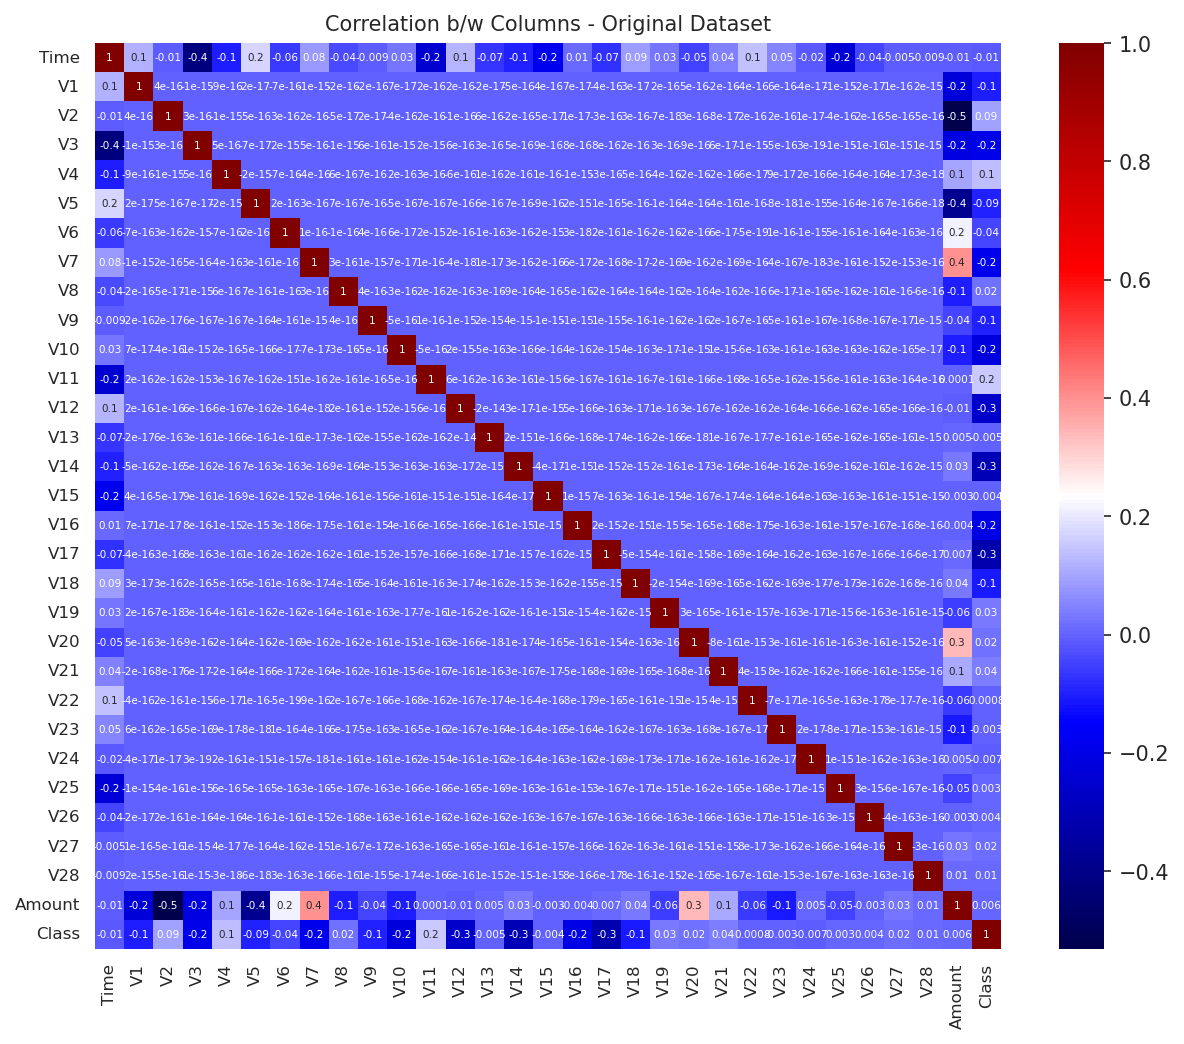

In [8]:
corr_orig = df_orig.corr()
fig = plt.figure(figsize=(10,8), dpi=150)
sns.heatmap(corr_orig, square=True, annot=True, fmt='0.1g', cmap='seismic', annot_kws={'size' : 5})
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Correlation b/w Columns - Original Dataset', fontsize=10);

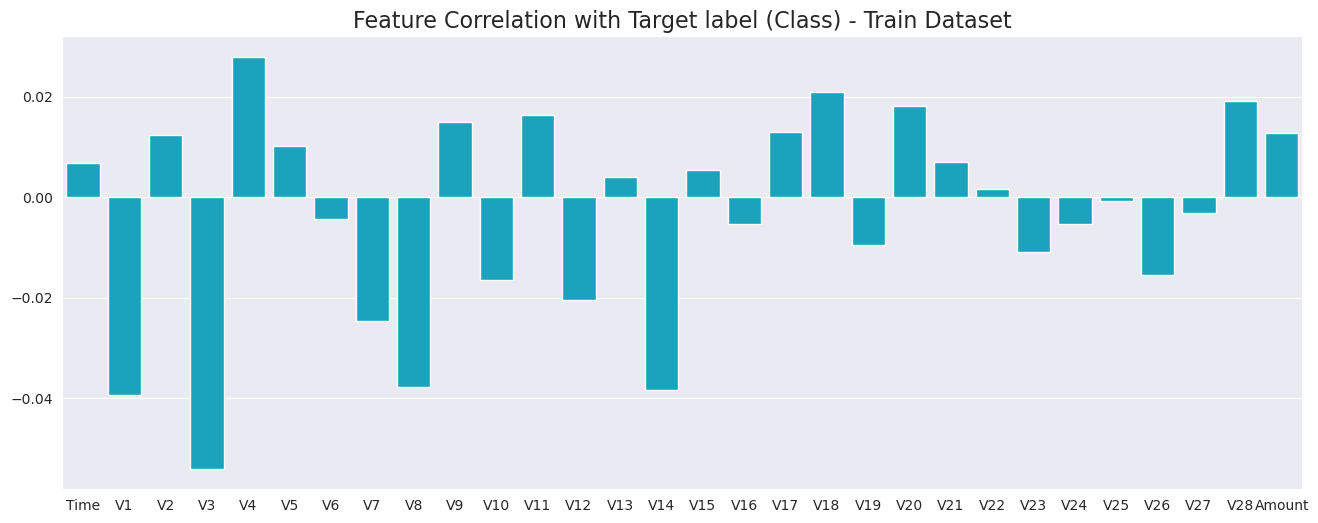

In [9]:
target_corr_train = df_train.corr()['Class'][1:-1]
plt.figure(figsize=(16, 6), dpi=100)
sns.barplot(x=target_corr_train.index, y=target_corr_train.values, palette=color1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Feature Correlation with Target label (Class) - Train Dataset', fontsize=16);

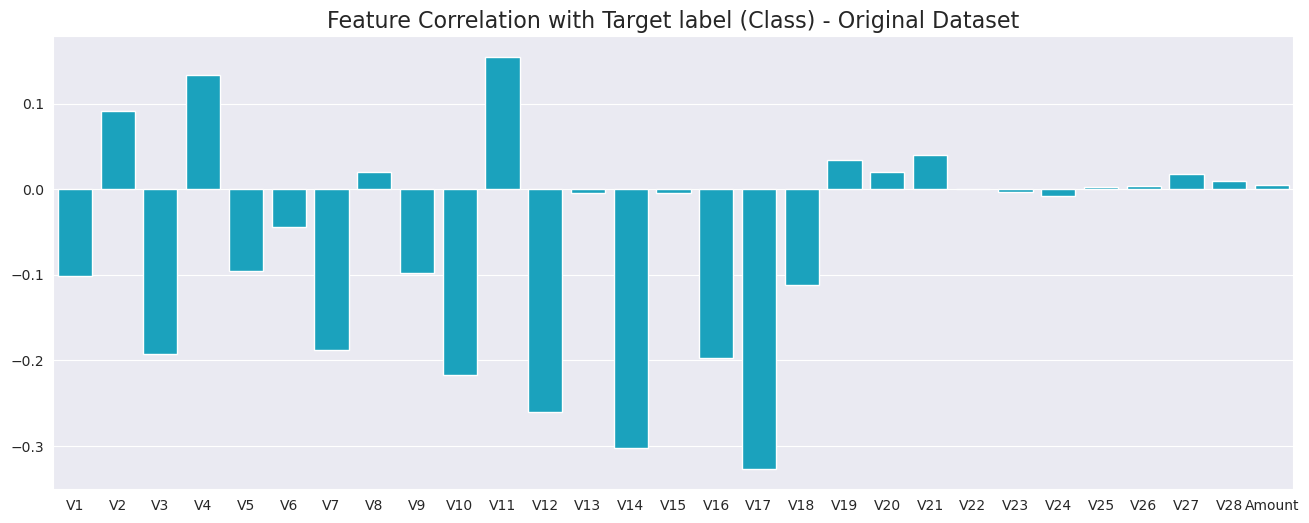

In [10]:
target_corr_orig = df_orig.corr()['Class'][1:-1]
plt.figure(figsize=(16, 6), dpi=100)
sns.barplot(x=target_corr_orig.index, y=target_corr_orig.values, palette=color1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Feature Correlation with Target label (Class) - Original Dataset', fontsize=16);

**Insights:**

* It is interesting to note that there are no correlation between columns in the original dataset.


* The train dataset and original dataset appear to be vastly dissimilar. As a result, we will proceed with training the model exclusively on the train dataset.

# Pre-Processing

In [11]:
train = df_train.drop('id', axis=1)
test = df_test.drop('id', axis=1)

### Scaling

In [12]:
scaler = StandardScaler()
train[continous_cols] = scaler.fit_transform(train[continous_cols])
test[continous_cols] = scaler.transform(test[continous_cols])

In [13]:
X_train = train.drop('Class', axis=1)
y_train = train['Class']
X_test = test.copy()

# Baseline Models

We will train multiple machine learning models, including Logistic Regression, LGBM Classifier, XGBoost Classifier, and CatBoost Classifier, to evaluate the AUC score.

In [14]:
SEED = 8888

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

# Model definition
clfs = {'Logistic Regression' : LogisticRegression(max_iter=100000, random_state=SEED, class_weight='balanced'),
        'LGBM Classifer' : LGBMClassifier(),
        'XGBoost' : XGBClassifier(), 
        'CatBoost' : CatBoostClassifier(verbose=False, eval_metric='AUC', task_type='GPU')}

auc_train = []

models = []

for estimator in clfs.values():
    
    auc_scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]

        model = estimator.fit(X_train_fold, y_train_fold)
        y_val_proba = model.predict_proba(X_val_fold)[:, 1]
        score = roc_auc_score(y_val_fold, y_val_proba)
        auc_scores.append(score)
        
    mean_score = np.mean(auc_scores)
    auc_train.append(mean_score)
    
    if mean_score >= 0.70:
        models.append(model)

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


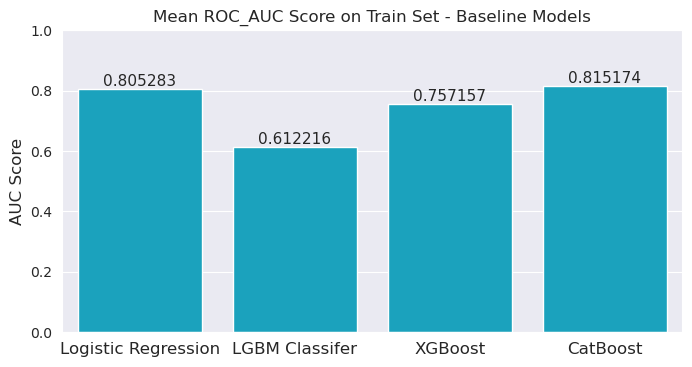

In [15]:
df_auc_score = pd.DataFrame(auc_train)
df_auc_score.index = clfs.keys()
df_auc_score = df_auc_score.reset_index()
df_auc_score = df_auc_score.rename(columns={'index': 'Model', 0 : 'mean_ROC_AUC'})

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
sns.barplot(data=df_auc_score, x='Model', y='mean_ROC_AUC', palette=color1)
ax.set_xlabel('')
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_ylim(0.0, 1.0)
ax.set_ylabel('AUC Score', fontsize=12)
ax.set_title('Mean ROC_AUC Score on Train Set - Baseline Models', fontsize=12)

for i in ax.containers:
    ax.bar_label(i, fontsize=11);

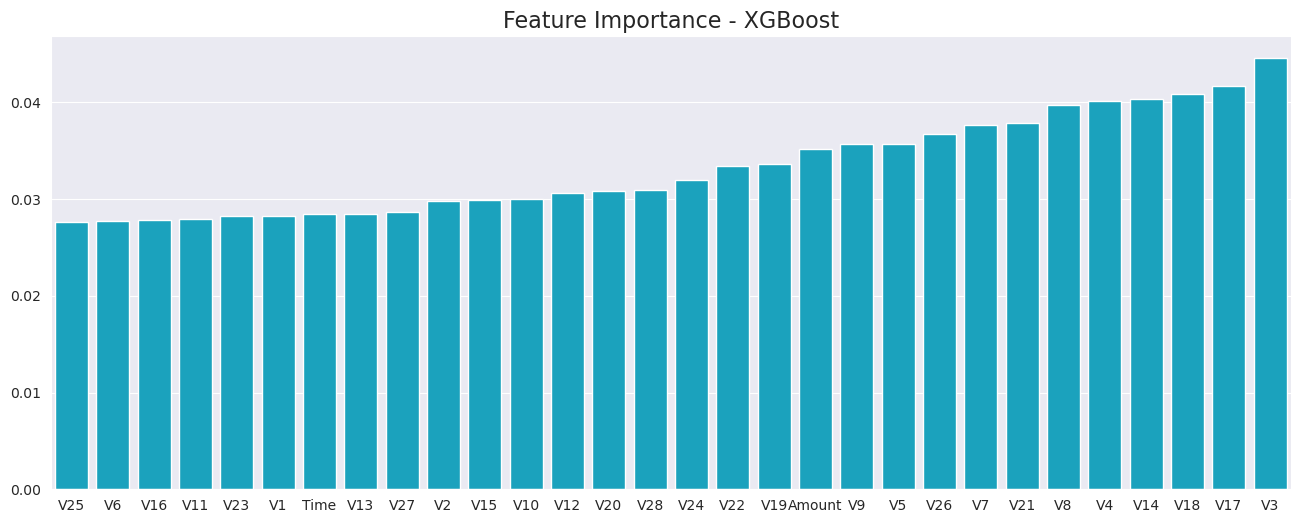

In [16]:
# Feature Importance - XGB Classifier
feat_imp_xgb = pd.Series(models[1].feature_importances_, index=X_train.columns).sort_values()

plt.figure(figsize=(16, 6), dpi=100)
sns.barplot(x=feat_imp_xgb.index, y=feat_imp_xgb.values, palette=color1)
plt.title("Feature Importance - XGBoost", fontsize=16);

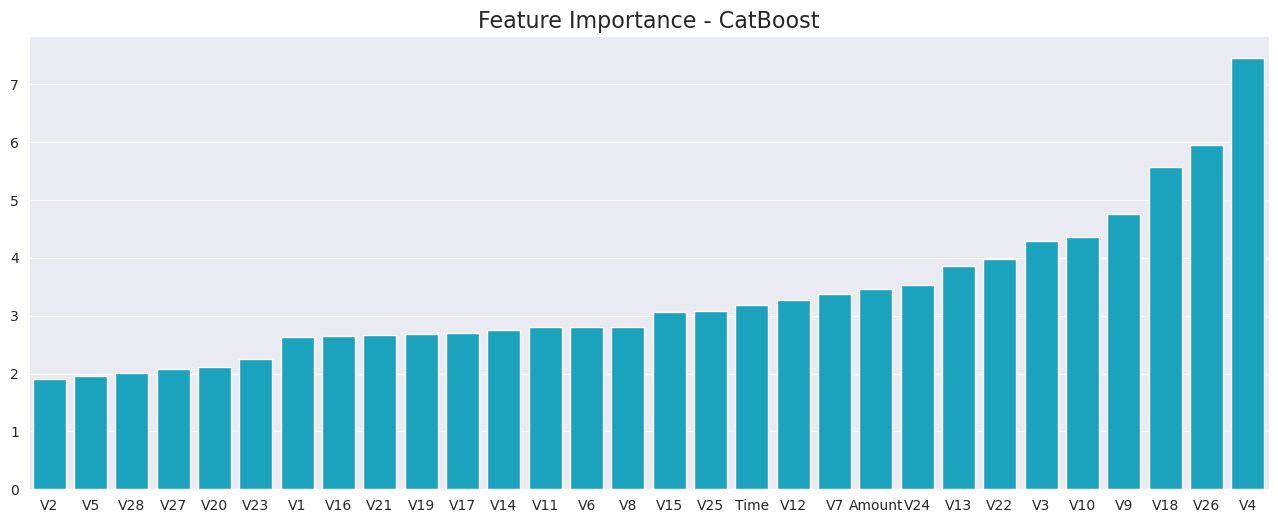

In [17]:
# Feature Importance - CatBoost
feat_imp_catboost = pd.Series(models[2].feature_importances_, index=X_train.columns).sort_values()

plt.figure(figsize=(16, 6), dpi=100)
sns.barplot(x=feat_imp_catboost.index, y=feat_imp_catboost.values, palette=color1)
plt.title("Feature Importance - CatBoost", fontsize=16);

# Ensembling Baseline Models - Voting Classifier

In [18]:
ensemble_voting_model = VotingClassifier(
    estimators=[('logreg', models[0]), ('xgb', models[1]), ('catboost', models[2])], voting='soft')

ensemble_voting_model.fit(X_train, y_train)

Default metric period is 5 because AUC is/are not implemented for GPU


VotingClassifier(estimators=[('logreg',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=100000,
                                                 random_state=8888)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthw...
                                            learning_rate=0.300000012,
                                            max_bin=256, max_cat

In [19]:
y_test_pred = ensemble_voting_model.predict_proba(X_test)[:, 1]
predictions = pd.DataFrame({'id' : df_test['id'], 'Class' : y_test_pred})
predictions.head()

,id,Class
0,219129,0.106595
1,219130,0.089895
2,219131,0.045979
3,219132,0.156092
4,219133,0.080876


In [20]:
output = predictions.to_csv("submission_voting_ensemble_baseline.csv", index=False)

# Oversampling with SMOTE

The Synthetic Minority Over-sampling Technique (SMOTE) can be used to address the challenge of imbalanced data by generating synthetic samples of the minority class (i.e. Class == 1) to balance the dataset. 

In [21]:
def run_model_smote(estimator):
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

    auc_scores = []
    
    sampling_params = {'sampling_strategy' : 'auto', 'random_state' : SEED}
    
    oversampling = SMOTE(**sampling_params)
        
    for train, val in cv.split(X_train, y_train):

        pipeline = make_pipeline(oversampling, estimator)  
        
        model = pipeline.fit(X_train.iloc[train], y_train.iloc[train])
        
        y_val_proba = model.predict_proba(X_train.iloc[val])[:, 1]
        
        auc_scores.append(roc_auc_score(y_train.iloc[val], y_val_proba))
        

    mean_score = np.mean(auc_scores)
    auc_smote.append(mean_score)
    
    if mean_score >= 0.7:
        smote_models.append(model)

In [22]:
auc_smote = []
smote_models = []

for estimator in clfs.values():
    run_model_smote(estimator)

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


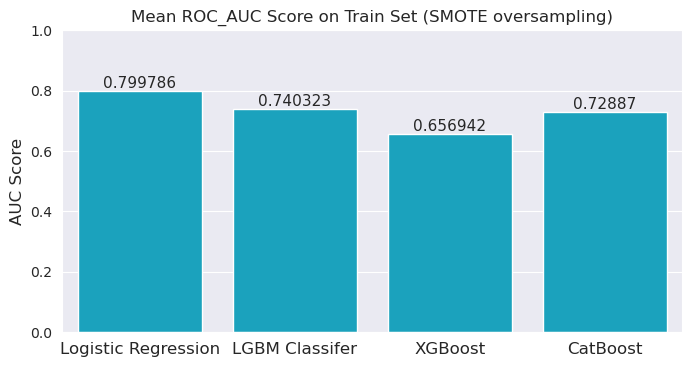

In [23]:
df_oversampled_auc = pd.DataFrame(auc_smote)
df_oversampled_auc.index = clfs.keys()
df_oversampled_auc = df_oversampled_auc.reset_index()
df_oversampled_auc = df_oversampled_auc.rename(columns={'index': 'SMOTE+Model', 0 : 'mean_ROC_AUC'})

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
sns.barplot(data=df_oversampled_auc, x='SMOTE+Model', y='mean_ROC_AUC', palette=color1)
ax.set_xlabel('')
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_ylim(0.0, 1.0)
ax.set_ylabel('AUC Score', fontsize=12)
ax.set_title('Mean ROC_AUC Score on Train Set (SMOTE oversampling)', fontsize=12)

for i in ax.containers:
    ax.bar_label(i, fontsize=11);

**Insights:**

* The LGBM model demonstrated an enhancement in its AUC score when applied to the oversampled data, while the logistic regression model and CatBoost did not show any improvement. On the other hand, the XGBoost performed poorly on the oversampled training data.

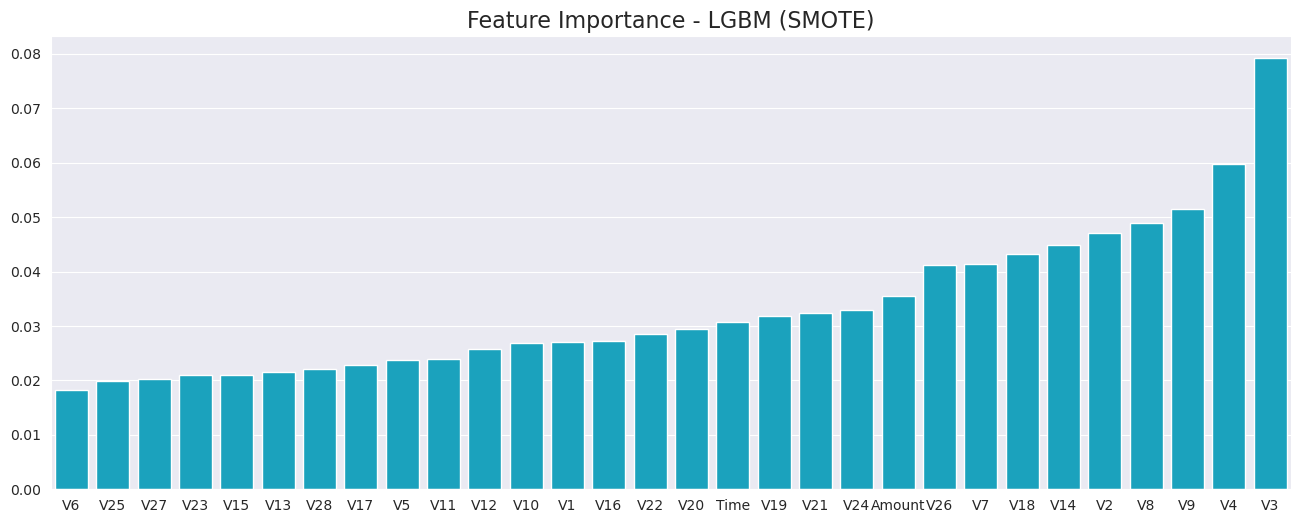

In [24]:
# Feature Importance - LGBM
feat_imp_lgbm = pd.Series(models[1].feature_importances_, index=X_train.columns).sort_values()

plt.figure(figsize=(16, 6), dpi=100)
sns.barplot(x=feat_imp_lgbm.index, y=feat_imp_lgbm.values, palette=color1)
plt.title("Feature Importance - LGBM (SMOTE)", fontsize=16);

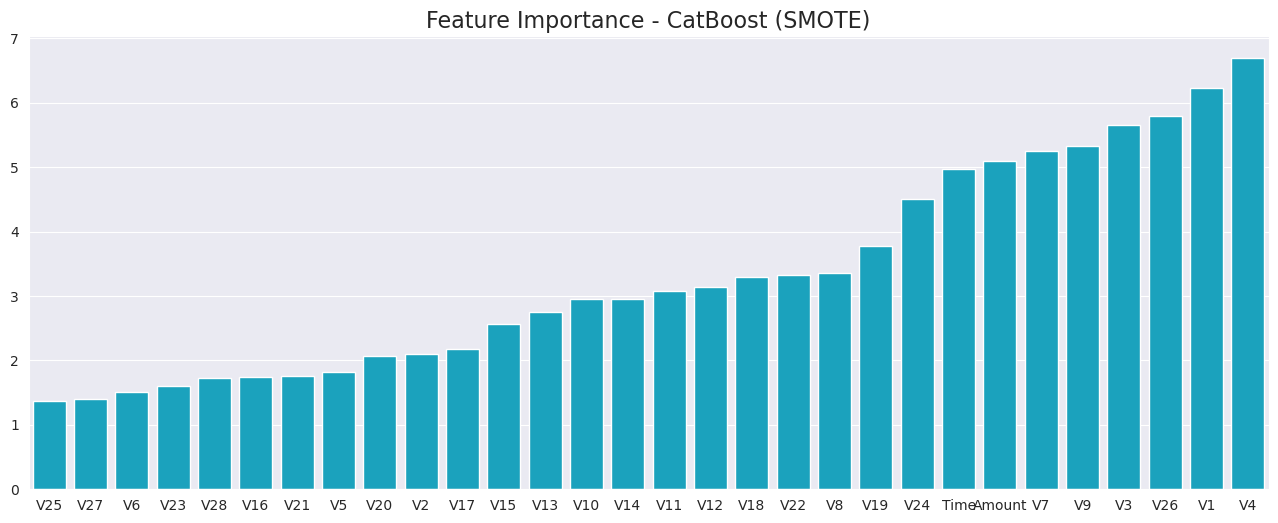

In [25]:
# Feature Importance - CatBoost
feat_imp_catboost = pd.Series(models[2].feature_importances_, index=X_train.columns).sort_values()

plt.figure(figsize=(16, 6), dpi=100)
sns.barplot(x=feat_imp_catboost.index, y=feat_imp_catboost.values, palette=color1)
plt.title("Feature Importance - CatBoost (SMOTE)", fontsize=16);

# Voting Classifier (Oversampled)

* We will implement the ensemble voting classifier that trains on logistic regression, LGBM, and CatBoost classifiers, and predict the target label (`Class`) for the oversampled data.

In [26]:
ensemble_voting_model_over = VotingClassifier(
    estimators=[('logreg', smote_models[0]), ('lgbm', smote_models[1]), ('catboost', smote_models[2])], voting='soft')

ensemble_voting_model_over.fit(X_train, y_train)

Default metric period is 5 because AUC is/are not implemented for GPU


VotingClassifier(estimators=[('logreg',
                              Pipeline(steps=[('smote',
                                               SMOTE(random_state=8888)),
                                              ('logisticregression',
                                               LogisticRegression(class_weight='balanced',
                                                                  max_iter=100000,
                                                                  random_state=8888))])),
                             ('lgbm',
                              Pipeline(steps=[('smote',
                                               SMOTE(random_state=8888)),
                                              ('lgbmclassifier',
                                               LGBMClassifier())])),
                             ('catboost',
                              Pipeline(steps=[('smote',
                                               SMOTE(random_state=8888)),
                       

In [27]:
y_test_pred_over = ensemble_voting_model_over.predict_proba(X_test)[:, 1]
predictions_over = pd.DataFrame({'id' : df_test['id'], 'Class' : y_test_pred_over})
predictions_over.head()

,id,Class
0,219129,0.135180
1,219130,0.101074
2,219131,0.037275
3,219132,0.176893
4,219133,0.068973


In [28]:
output = predictions_over.to_csv("submission_voting_ensemble_smote.csv", index=False)